# 実験 5 量子位相推定の精度

前提条件

- [Ch.3.5 量子フーリエ変換](/course/ch-algorithms/quantum-fourier-transform)
- [Ch.3.6 量子位相推定](/course/ch-algorithms/quantum-phase-estimation)

その他の関連資料

- [QCQI] マイケル A. ニールセンとアイザック L. チュアン。 2011. 量子計算と量子情報

In [2]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt

## パート 1: 量子位相推定のパフォーマンス

**ゴール**

高確率で位相推定の望ましい精度に必要な量子ビット数間の関係を調査します。

量子位相推定 (QPE) による推定値の精度とその成功確率は、QPE 回路で使用される量子ビットの数によって異なります。したがって、特に決定する必要がある位相が有限ビットのバイナリ展開で分解できない場合、目標レベルの QPE パフォーマンスを達成するために必要な量子ビット数を知りたい場合があります。このラボのパート 1 では、望ましい精度を達成するために必要な量子ビットの数と、QPE による位相の決定の成功確率を調べます。

### 1. 4 つの計数量子ビットを使用して $2^{-2}$ まで正確な位相値の推定値を正常に取得できる確率を求めます。

#### 📓ステップ A. 4 つの計数量子ビットを使用して QPE 回路を設定し、回路を変数 'qc4' に保存します。 qasm シミュレーターで「qc4」を実行します。結果のヒストグラムをプロットします。

回路については、Qiskit 教科書の QPE の章を確認してください ( `3. Example: Getting More Precision` [)](/course/ch-algorithms/quantum-phase-estimation) 。

In [7]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [1]:
## Start your code to create the circuit, qc4











qc4.draw()

In [8]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('qasm_simulator')
shots = 20000
count_qc4 = execute(qc4, sim, shots=shots).result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

`Step A`を正常に実行すると、以下に示す分布と同様の分布が`0101`で最も高い確率で得られます。これは推定 $\phi$ 値`0.3125`に対応します。

![](images/L5_qc4_hist.png)

回路に使用される計数量子ビットの数は 4 であるため、最良の推定値は $\delta = 2^{-4} = 0.0625$ まで正確であるはずです。ただし、 $\theta = 1/3$ は有限のビット数で表現できないため、考えられる結果は複数あり、ここでの QPE による推定は常にこの精度に制限されるわけではありません。 

次のセルを実行すると、同じヒストグラムが表示されますが、X 軸には考えられるすべての推定 $\phi$ 値が表示されます。

In [5]:
phi_est = np.array([round(int(key, 2)/2**t,3) for key in list(count_qc4.keys())])
key_new = list(map(str, phi_est))
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

**最終測定の結果が $m$ であると仮定し、$b$ をこの場合の`0.3125`である最良の推定値とします。**

#### 📓ステップ B. $|m - b のとき、すべての結果 'm' が $\phi$ を精度 $2^{-2}$ に近似するように、最良の推定値<code>0101</code>からの整数の最大差である $e$ を見つけます。 | \leq \frac{e}{2^{t}}$。 

この場合、$t$ と $b$ の値はそれぞれ $4$ と $0.3125$ になります。

たとえば、 $e = 1$ の場合、考慮される結果は`0100` 、 `0101` 、 `0110`で、それぞれ $m$ の値 $0.25、~0.312、~0.375$ に対応し、それらはすべて $\frac の値に近似します。 {1}{3}$ の精度は $2^{-2}$ です。

In [2]:
## Your code goes here











#### 📓ステップ C. 精度 $2^{-2}$ まで正しい近似が得られる確率を計算します。計算された確率値が $1- \frac{1}{2(2^{(tn)}-2)}$ 以上であることを確認します。ここで、$t$ はカウント ビット数であり、$2^{-n }$ は必要な精度です。 

$\phi$ を精度 $2^{-2}$ に近似するすべての結果は、最良の推定値との最大差 $e$ に基づいて見つけることができるため、ヒストグラムから成功の確率を評価するのは簡単です。 

In [3]:
## Your code goes here














### 2. 計数量子ビットの数 $t$ が 4 から 9 まで変化する場合の精度 $2^{-2}$ の成功確率を計算します。 $2^{-n}$ が望ましい精度であり、$\epsilon$ が 1 - 成功の確率である場合、結果を方程式 $t=n+log(2+\frac{1}{2\epsilon})$ と比較します。 。 

次のプロットは、計数量子ビットの数 t と、位相を $2^{-2}$ の精度で近似する成功の最小確率との関係を示しています。 Chを確認してください。 5.2.1 `[QCQI]`のパフォーマンスと要件。

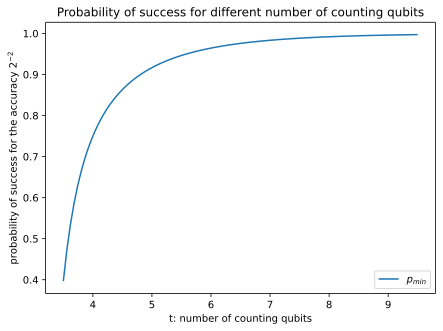

In [3]:
y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

#### 📓ステップ A. $t = [4, 5, 6, 7, 8, 9]$。 Lab3 で行ったように、すべての回路をリスト変数 'c​​irc' に保存して、すべての回路を一度にシミュレーションします。 

In [15]:
## Your Code to create the list variable 'circ' goes here



















In [4]:
# Run this cell to simulate `circ` and plot the histograms of the results

results = execute(circ, sim, shots=shots).result()

n_circ = len(circ)
counts = [results.get_counts(idx) for idx in range(n_circ)]

fig, ax = plt.subplots(n_circ,1,figsize=(25,40))
for idx in range(n_circ):
    plot_histogram(counts[idx], ax=ax[idx])
plt.tight_layout()

#### 📓ステップ B. $e$、異なる数の計数量子ビットの最良推定値からの整数の最大差、$t = [4, 5, 6, 7, 8, 9]$ を決定します。この場合、必要な精度は $2^{-2}$ であるため、$n=2$ の関係 $e=2^{tn}-1$ を確認します。 

In [17]:
## Your Code goes here



















すべての計数量子ビット $t=[4,5,6,7,8,9]$ の $e$ 値の計算に成功すると、関係 $e = 2^ を検証する次のグラフを生成できるようになります。 {t-2} -1$ を計算した $e$ 値に置き換えます。

![](images/L5_e_max.png)

#### 📓ステップ C. $t$ (計数量子ビットの数) のすべての値について、$\phi$ を $2^{-2}$ の精度で推定する成功確率を評価します。確率をリスト変数「prob_success」に保存します。 

In [19]:
## Your code to create the list variable, 'prob_success',  goes here




















#### 📓ステップ D. ステップ C の結果を、計数量子ビットの数 $t$ と最小成功確率の関係を示すグラフに重ねて、精度 $2^{-2}$ まで位相を近似します。結果を理解してください。 

In [4]:
## Your code goes here























![](images/L5_prob_t.png)

プロットは上記と同様になるはずです。左側のパネルの折れ線グラフは、計数量子ビットの数が変化するにつれて、精度 $2^{-2}$ 内で $\phi$ を推定する最小成功確率を示します。重ね合わされたオレンジ色の点は同じ値ですが、線プロットが下限として表す関係を確認するシミュレーションによるものです。右側のパネルには同じ結果が表示されますが、y 軸の範囲を調整することで拡大されています。

次のグラフは、さまざまな精度レベルとの関係を示しています。関係 $t=n+log(2+\frac{1}{2\epsilon})$ は、$\phi$ を精度 $2^{-2}$ で推定するための計数量子ビット $t$ の数を示します。上で検証したように、成功の確率は少なくとも $1-\epsilon$ です。 

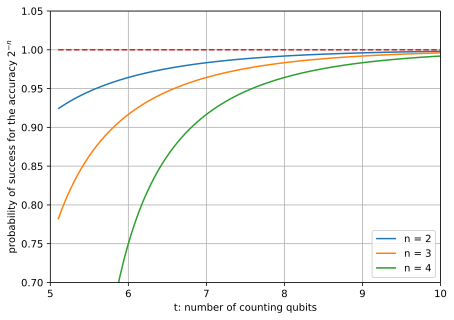

In [4]:
t = np.linspace(5.1, 10, 100)
prob_success_n = [y(t, n) for n in [2, 3, 4]]
prob_n2, prob_n3, prob_n4  = prob_success_n[0], prob_success_n[1], prob_success_n[2]

plt.figure(figsize=(7, 5))
plt.plot(t, prob_n2, t, prob_n3, t, prob_n4, t, [1]*len(t),'--' )
plt.axis([5, 10, 0.7, 1.05])
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-n}$')
plt.legend(['n = 2', 'n = 3', 'n = 4'], loc='lower right')
plt.grid(True)

## パート 2: ノイズのある量子システム上の QPE

**ゴール**

実際の量子システムで QPE 回路を実行して、ノイズの多い量子システムを使用した場合の結果と制限を理解する

第 1 部で実行した精度分析は、QPE 回路が現在のノイズの多い量子システムで実行される場合には正しくありません。パート 2 では、IBM Quantum Experience のバックエンドで回路を実行して QPE 結果を取得し、ノイズが結果にどのような影響を与えるかを調べ、その影響を軽減するテクニックを学びます。 

#### 📓ステップ A. アカウントをロードし、プロバイダーからバックエンドを選択します。 

In [ ]:
## Your code goes here.  









#### 📓ステップ B. 最初のパート 1 で設定した<code>qc4</code>のトランスパイル済み回路を複数 (必要なだけ) 生成します。回路深さが最小の一方を選択し、回路深さが最大のもう一方を選択します。

結果の誤差を減らすために、パラメータ`optimization_level = 3`を使用して回路をトランスパイルします。ラボ 1 で学んだように、Qiskit はデフォルトで確率的スワップ マッパーを使用して必要な SWAP ゲートを配置します。これにより、同じランタイム設定でもトラップされた回路の結果が変化します。したがって、結果の誤差を小さくするためにより短い深さのトランスパイルされた回路を実現するには、 `qc4`複数回トランスパイルし、最小の回路深さを持つ回路を選択します。比較のために、最大回路深さ 1 も選択します。 

In [138]:
## Your code goes here












#### 📓ステップ C. 選択したバックエンドで両方の回路を実行します。結果のヒストグラムをプロットし、パート 1 のシミュレーション結果と比較します。

In [6]:
## Your code goes here














以下にサンプル結果を示します。

![](images/L5_QPEresults.png)

#### ステップ D. 測定エラーの軽減 

前のステップでは、Qiskit トランスパイラーに関する知識を利用して最良の結果を得ました。ここでは、ラボ 3 で学んだ測定軽減テクニックを使用して、結果の誤差をさらに軽減しようとします。

📓関数「complete_meas_cal」を使用して、すべての基底状態の測定誤差をプロファイルする回路を構築します。測定フィルター オブジェクト「meas_filter」を取得します。これは、読み取り (測定) エラーを軽減するためにノイズの多い結果に適用されます。

In [1]:
##  Your Code goes here














📓測定誤差を軽減する前後の結果のヒストグラムをプロットして、改善を示します。

In [ ]:
## Your Code goes here















次のプロットはサンプル結果を示しています。 

![](images/L5_QPEresults_final.png)

以下の図は、測定誤差の軽減を適用した後の最良の SWAP マッピング ケースと最悪の SWAP マッピング ケースのサンプル最終結果を含むシミュレーション結果を示しています。実験 3 では、誤差の主な原因が測定にあったため、誤差軽減手順の後、結果は大幅に改善されました。ただし、QPE の場合、測定誤差は結果のノイズの主な原因ではないようです。 CNOT ゲート エラーがノイズ プロファイルを支配します。この場合、結果のエラーを減らすためには、深さが最も浅いトランスパイルされた回路を選択することが重要な手順でした。

![](images/L5_QPE_final.png)